# Reinforcement Learning Tutorial - Taxi pickup problem

Welcome to the practical component of this Reinforcement Learning (RL) tutorial! 

In order to experiment with different RL algorithms and understand how they work, their characteristics, and important challanges in RL, we have prepared a relatively simple toy problem. The idea was to have a problem that is easy to understand and relate to, but at the same time is computatinally efficient (we cannot wait 1h for an algorithm to run in the context of a tutorial) and one where learned policies can be easily visualized. 

<img src="http://mlsm.man.dtu.dk/env.gif"/>

**Problem:** The problem that we will consider is the Taxi pickup problem, where to goal is to pickup customers in a simple 5x5 grid world in order to maximize profit. Real-world extensions of this toy problem could be, for example: 

- Dynamic routing of a fleet of autonomous vehicles (e.g. each vehicle needs to decide where to roam and which routes to take)

- Rebalancing in shared mobility services (e.g. SHARENOW or Green Mobility)

- Managing a fleet of autonomous vehicles in a warehouse

- Etc.

**Environments:** We will consider 3 environments of increasing complexity:

1. An environment where there is only a single request at a fixed location, and all the taxi needs to learn to do is to go to that location and pickup the customer. The episode terminates after.

2. An environment with 3 different pickup locations. The customers spawn at these locations with different rates. Every time a customer is picked up the taxi is teleported to a random dropout location and continues from there.

3. An environment where requests can appear anywhere in the map at any time.

**Actions:** For all environments, at each time step, the taxi is allowed to take one of the following 5 actions:
- 0: move south
- 1: move north
- 2: move east 
- 3: move west 
- 4: pickup passenger

Before we move on, let's make sure that you have installed all the necessary Python packages. Uncomment the following lines of code and run them:

In [ ]:
#!pip install numpy scipy matplotlib

In [1]:
#!pip install gym

In [2]:
#!pip install keras

In [3]:
#!pip install keras-rl2

**The following is necessary for Colab:**

In [ ]:
!wget http://mlsm.man.dtu.dk/taxi_env.py

### Imports

Next we are going to import the Python packages that we will be using:

In [4]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Embedding, Reshape
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

import gym

from taxi_env import TaxiPickupEnvSimplified, TaxiPickupEnvStandard, TaxiPickupEnvAdvanced

plt.style.use("ggplot")

# Part 1: Simplified environment (Q-learning)

In this first part, we will consider a very simple environment where the goal is to drive the taxi to the target location indicated in the grid world by a red 'T'. The taxi is represented by a yellow rectangle. The 5x5 grid world has a few maze-like walls that prevent the taxi to take certain actions when in some positions (i.e. the action has no effect). The taxi has no intermediate rewards. Only one final big reward when it accomplishes the goal (reach the target and take action "pickup"). Note also that the taxi has no information about the environment besides its current position (row and column). It has no idea how the environment works and what leads to high rewards!

Let's formalize the MDP for this problem:

**Actions:** north, south, east, west, pickup

**State:** position of the taxi (5x5=25 possible states)

**Reward:** +20 if taxi at target location ("T") and action is "pickup", else -1 (penalty for time elapsed); trying to pickup in a location different than the target also leads to penalty of -10.

Implementation details: we have implemented the environment as a class extension of the popular OpenAI Gym. The ``TaxiPickupEnvSimplified`` class therefore extends the ``discrete.Env`` of OpenAI Gym, and provides the following methods:

- ``state = env.reset()`` - resets the environment to a random initial state and returns that state;

- ``new_state, reward, done, info = env.step(action)`` - takes the ``action`` passed in the argument (integer) and returns the new state, the reward obtained, a boolean ``done`` indicating whether the episode has terminated, and some extra ``info`` (not relevant to this environment);

- ``env.render()`` - visualizes the current state of the environment;

- ``env.close()`` - terminates the environment.

Suggestion: have a look at the ``taxi_env.py`` file to see how the environment dynamics in the ``step()`` function of the ``TaxiPickupEnvSimplified`` class are implemented.

### Run Random Policy

Let us start by exploring the environment and the functionality described above using a random policy (i.e. taking random actions in the environment). Analyze the code below and run it (note that you can stop execution at any time). Make sure that everything makes sense to you.

In [5]:
env = TaxiPickupEnvSimplified()
env.reset()
for _ in range(1000):
    try:
        env.render()
        env.step(env.action_space.sample()) # take a random action
        time.sleep(1)
        clear_output(wait=True)
    except KeyboardInterrupt:
        break
env.close()

+---------+
| : | : : |
| : | : : |
| : : : : |
| | : | : |
|T| : | : |
+---------+
T: 15; Total earnings: 0
Action: South; Reward: -1


We can check properties of the environment ``env`` such as the action space and the observation/state space using the code below. You can check other properties available by writting "env." and then pressing TAB in a cell, although they are not necessary for this tutorial.

In [6]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(5)
State Space Discrete(25)


### Tabular Q-learning

You will now implement a Q-learning algorithm for learning an implicit policy that tries to optimize rewards in the environment described above. 

Since the states are discrete, we can represent the Q-function using a table with 25 rows (because there are 5x5 possible states) and 5 columns (because there are 5 possible actions). Each cell then contains the expected future rewards when the agent takes a certain action when in a given state. The Q-learning algorithm can then be summarized as follows:

1. initialize Q-table $\hat{Q}_\phi$ (e.g. with zeros);
2. set learning rate $\alpha$, discount factor $\gamma$ and initial exploration parameter $\epsilon$;
3. repeat until maximum number of episodes has been reached:
    1. reset environment;
    2. repeat until episode ends or maximum number of steps is reached:
        1. choose action $a_i$ from $\epsilon$-greedy policy: with probability $\epsilon$ select a random action $a_i$, otherwise select $a_i = \arg \max_{a_i} \hat{Q}_\phi(s_i,a_i)$;
        2. take action $a_i$ in the environment and observe new state $s'_i$ and reward $r(s_i,a_i)$;
        3. compute target values $y_i \leftarrow r(s_i,a_i) + \gamma \max_{a'_i} \hat{Q}_\phi(s'_i,a'_i)$;
        4. update Q-table: $\hat{Q}_\phi(s_i,a_i) \leftarrow (1-\alpha) \hat{Q}_\phi(s_i,a_i) + \alpha y_i $;
    3. decay exploration parameter $\epsilon$;
    
Note that the algorithm described above uses an $\epsilon$-greedy exploration policy. In practice, one usually decays the value of $\epsilon$ over time, until a minimum value of $\epsilon$ is reached. Also, we will keep track of the rewards over time for later analysis and plotting.

So, let us begin by making the necessary initializations:

In [7]:
#Setting the hyperparameters
              
alpha = 0.6 #learning rate                 
discount_factor = 0.98               
epsilon = 1                  
max_epsilon = 1
min_epsilon = 0.01         
decay = 0.001

train_episodes = 5000   
# test_episodes = 100          
max_episode_len = 200

#Initializing the Q-table
Q = np.zeros((env.observation_space.n, env.action_space.n))
#Creating lists to keep track of reward and epsilon values
training_rewards = []  
epsilons = []
episode = 0

And now, it is time to implement the Q-learning algorithm as described above. Can you do it? (the skeleton of the code is already there)

In [8]:
for _ in range(train_episodes):
    episode += 1
    if episode % 200 == 0 and episode != 0:
        print("[Episode %d] Avg reward over last 10 episodes: %.3f" % (episode, np.mean(training_rewards[-10:])))
        print("alpha=%.3f; eps=%.3f" % (alpha, epsilon))
        
    # Reseting the environment each time as per requirement
    state = env.reset()    
    
    # Starting the tracker for the rewards
    total_training_rewards = 0
    for step in range(max_episode_len):
        
        # Choosing an action given the states based on a random number
        exp_exp_tradeoff = random.uniform(0, 1) 
        
        ### SECOND option for choosing the initial action - exploit     
        # If the random number is larger than epsilon: employing exploitation 
        # and selecting best action 
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(Q[state,:]) 
        
        ### FIRST option for choosing the initial action - explore       
        # Otherwise, employing exploration: choosing a random action 
        else:
            action = env.action_space.sample()
        
        ### performing the action and getting the reward     
        # Taking the action and getting the reward and outcome state
        new_state, reward, done, info = env.step(action)

        ### update the Q-table
        # Updating the Q-table using the Bellman equation
        Q[state, action] = Q[state, action]+alpha*(reward+discount_factor*np.max(Q[new_state, :])-Q[state, action]) 
        
        # Increasing our total reward and updating the state
        total_training_rewards += reward      
        state = new_state         
        
        # Ending the episode
        if done == True:
            break
            
    # Cutting down on exploration by reducing the epsilon 
    epsilon = min_epsilon+(max_epsilon-min_epsilon)*np.exp(-decay*episode)
    
    # Adding the total reward and reduced epsilon values
    training_rewards.append(total_training_rewards)
    epsilons.append(epsilon)
    
print ("Training score over time: " + str(sum(training_rewards)/train_episodes))

[Episode 200] Avg reward over last 10 episodes: -88.600
alpha=0.600; eps=0.821
[Episode 400] Avg reward over last 10 episodes: -27.500
alpha=0.600; eps=0.674
[Episode 600] Avg reward over last 10 episodes: -0.700
alpha=0.600; eps=0.554
[Episode 800] Avg reward over last 10 episodes: 0.200
alpha=0.600; eps=0.455
[Episode 1000] Avg reward over last 10 episodes: 3.100
alpha=0.600; eps=0.375
[Episode 1200] Avg reward over last 10 episodes: 4.600
alpha=0.600; eps=0.308
[Episode 1400] Avg reward over last 10 episodes: 14.300
alpha=0.600; eps=0.254
[Episode 1600] Avg reward over last 10 episodes: 10.400
alpha=0.600; eps=0.210
[Episode 1800] Avg reward over last 10 episodes: 11.600
alpha=0.600; eps=0.174
[Episode 2000] Avg reward over last 10 episodes: 12.000
alpha=0.600; eps=0.144
[Episode 2200] Avg reward over last 10 episodes: 14.000
alpha=0.600; eps=0.120
[Episode 2400] Avg reward over last 10 episodes: 13.300
alpha=0.600; eps=0.100
[Episode 2600] Avg reward over last 10 episodes: 14.800
a

Did the rewards improve?

Let's plot the evolutions of episodic rewards over time:

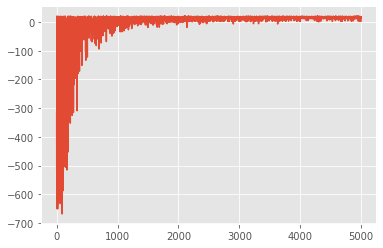

In [9]:
plt.plot(training_rewards);

And also the values of $\epsilon$ (useful for debugging purposes and tweaking the decay rate):

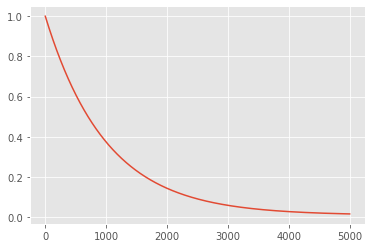

In [10]:
plt.plot(epsilons);

We can now visualize the (implicit) policy learned in the Q-table to see if it corresponds to good behaviour in practice:

In [11]:
env = TaxiPickupEnvSimplified()
state = env.reset()
for _ in range(1000):
    try:
        env.render()
        action = np.argmax(Q[state,:])
        state, reward, done, info = env.step(action)
        time.sleep(1)
        clear_output(wait=True)
        if done == True:
            env.render()
            break
    except KeyboardInterrupt:
        break
env.close()

+---------+
| : | : : |
| : | : : |
| : : : : |
| | : | : |
|T| : | : |
+---------+
T: 6; Total earnings: 0
Action: South; Reward: -1


How good is the policy learned? Does it do what you expected it to do?

We can further inspect the Q-values for different actions for when the taxi is in a certain position:

In [12]:
taxi_loc = (1,2)
print("Q-values for different actions a when taxi in location", taxi_loc)
for a in range(env.nA):
    print("Action a=%s\t Q[s,a]=%.1f" % (env.action_names[a], Q[env.encode(taxi_loc),a]))

Q-values for different actions a when taxi in location (1, 2)
Action a=South	 Q[s,a]=899.1
Action a=North	 Q[s,a]=861.5
Action a=East	 Q[s,a]=861.5
Action a=West	 Q[s,a]=880.1
Action a=Pickup	 Q[s,a]=871.1


If all went well, the maximum Q-value should correspond to the action that takes the taxi towards the target the most from that position.

Lastly, we can derive the value function (value table, in this case) that correspond to that Q-table. Remember, the value function tells us the value of being in a certain state (i.e. expected future rewards averaged over all possible actions according to the current policy $\pi$):

\begin{align}
V^\pi(s) = \mathbb{E}_{a \sim \pi(a|s)}[ Q^\pi(s,a) ]  \nonumber
\end{align}

Since in Q-learning, the agent always chooses the action that maximizes $Q^\pi(s_t,a_t)$ (well, unless during training where it uses $\epsilon$-greedy to explore), the value function is simply given by:

\begin{align}
V^\pi(s) = \max_a  Q^\pi(s,a)   \nonumber
\end{align}

Let's compute the value table and visualize it by color-coding it according to its values:

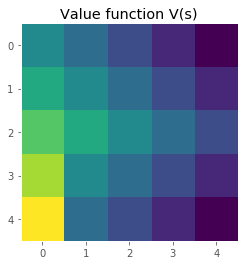

In [13]:
V = np.zeros((env.num_rows, env.num_columns))
for s in range(env.nS):
    taxi_row, taxi_col = env.decode(s)
    V[taxi_row, taxi_col] = max([Q[s,a] for a in range(env.nA)]) # max Q-value for all possible actions

plt.imshow(V)
plt.title("Value function V(s)")
plt.grid(False)
plt.show()

Does the result make sense to you? The closer the taxi is to the objective, the higher the value of that state should be.

# Part 2: Standard environment (Q-learning)

In this part, we will consider a more interesting version of the taxi pickup problem. There will now be 3 possible pickups locations (represented in Red, Green and Blue) where customers arrive with different rates. The number of customers currently waiting at a given pickups location is shown as a red, green and blue counters in the map. The goal is for the taxi to pickup customers and maximize reward. To simplify the environment implementation, when a customer is picked up, the taxi teleports to the destination and continues from there. 

With these changes, we now have a more complex environment and therefore we need a more complex representation to encode its state. There are still 5x5=25 possible locations for the taxi to be, but now, there can also be $2^3=8$ types of situations: 

- no customers waiting in any location

- customers waiting in red location, and no customers waiting elsewhere

- customers waiting in green location, and no customers waiting elsewhere 

- customers waiting in blue location, and no customers waiting elsewhere 

- customers waiting in red and green locations, and no customers waiting in blue location

- customers waiting in red and blue locations, and no customers waiting in green location

- customers waiting in green and blue locations, and no customers waiting in red location

- customers waiting in all 3 locations

Note that we do not differentiate between having 1 or 2 or N customers waiting at a location to simplify things.

Therefore, the state representation of the environment now has $5\times5\times2^3 = 200$ dimensions, and we need to estimate Q-values for all possible actions $a \in \mathcal{A}$ for all those 200 possible states! That is starting to look like a challanging task, right? And this is still a tiny 5x5 grid world... (more on scalability later :-)

In summary, the new MDP for this problem can be formalized as:

**Actions:** north, south, east, west, pickup

**State:** position of the taxi and status of requests at 3 different locations: $5\times5\times2^3 = 200$ dimensions

**Reward:** +20 if taxi at a pickup location where there are requests and action is "pickup", else -1 (penalty for time elapsed); trying to pickup in a location different than the target also leads to penalty of -10.

### Run Random Policy

We start again by trying out the environmenet using a random policy (note that you can stop execution at any time):

In [14]:
env = TaxiPickupEnvStandard()
env.reset()
for _ in range(1000):
    try:
        env.render()
        env.step(env.action_space.sample()) # take a random action
        time.sleep(1)
        clear_output(wait=True)
    except KeyboardInterrupt:
        break
env.close()

+---------+
| :0| : : |
| : | : : |
| : : : : |
| | : | : |
|0| : |0: |
+---------+
T: 5; Total earnings: 0
Action: South; Reward: -1


In [15]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(5)
State Space Discrete(200)


### Tabular Q-learning

We will now apply the same Q-learning algorithm that you've implemented above for the simplified environment. Can you take care of the missing code blocks?

In [16]:
#Setting the hyperparameters
              
alpha = 0.6 #learning rate                 
discount_factor = 0.98               
epsilon = 1                  
max_epsilon = 1
min_epsilon = 0.01         
decay = 0.001

train_episodes = 10000           
max_episode_len = 200

#Initializing the Q-table
Q = np.zeros((env.observation_space.n, env.action_space.n))

#Creating lists to keep track of reward and epsilon values
training_rewards = []  
epsilons = []
episode = 0

In [17]:
for _ in range(train_episodes):
    episode += 1
    if episode % 200 == 0 and episode != 0:
        print("[Episode %d] Avg reward over last 10 episodes: %.3f" % (episode, np.mean(training_rewards[-10:])))
        print("alpha=%.3f; eps=%.3f" % (alpha, epsilon))
        
    # Reseting the environment each time as per requirement
    state = env.reset()    
    
    # Starting the tracker for the rewards
    total_training_rewards = 0
    for step in range(max_episode_len):
        
        # Choosing an action given the states based on a random number
        exp_exp_tradeoff = random.uniform(0, 1) 
        
        ### SECOND option for choosing the initial action - exploit     
        # If the random number is larger than epsilon: employing exploitation 
        # and selecting best action 
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(Q[state,:]) 
        
        ### FIRST option for choosing the initial action - explore       
        # Otherwise, employing exploration: choosing a random action 
        else:
            action = env.action_space.sample()
        
        ### performing the action and getting the reward     
        # Taking the action and getting the reward and outcome state
        new_state, reward, done, info = env.step(action)

        ### update the Q-table
        # Updating the Q-table using the Bellman equation
        Q[state, action] = Q[state, action]+alpha*(reward+discount_factor*np.max(Q[new_state, :])-Q[state, action]) 
        
        # Increasing our total reward and updating the state
        total_training_rewards += reward      
        state = new_state         
        
        # Ending the episode
        if done == True:
            break
            
    # Cutting down on exploration by reducing the epsilon 
    epsilon = min_epsilon+(max_epsilon-min_epsilon)*np.exp(-decay*episode)
    
    # Adding the total reward and reduced epsilon values
    training_rewards.append(total_training_rewards)
    epsilons.append(epsilon)
    
print ("Training score over time: " + str(sum(training_rewards)/train_episodes))

[Episode 200] Avg reward over last 10 episodes: -356.600
alpha=0.600; eps=0.821
[Episode 400] Avg reward over last 10 episodes: -176.600
alpha=0.600; eps=0.674
[Episode 600] Avg reward over last 10 episodes: -91.100
alpha=0.600; eps=0.554
[Episode 800] Avg reward over last 10 episodes: 71.200
alpha=0.600; eps=0.455
[Episode 1000] Avg reward over last 10 episodes: 98.500
alpha=0.600; eps=0.375
[Episode 1200] Avg reward over last 10 episodes: 163.900
alpha=0.600; eps=0.308
[Episode 1400] Avg reward over last 10 episodes: 205.000
alpha=0.600; eps=0.254
[Episode 1600] Avg reward over last 10 episodes: 230.800
alpha=0.600; eps=0.210
[Episode 1800] Avg reward over last 10 episodes: 206.500
alpha=0.600; eps=0.174
[Episode 2000] Avg reward over last 10 episodes: 305.800
alpha=0.600; eps=0.144
[Episode 2200] Avg reward over last 10 episodes: 282.100
alpha=0.600; eps=0.120
[Episode 2400] Avg reward over last 10 episodes: 339.100
alpha=0.600; eps=0.100
[Episode 2600] Avg reward over last 10 episo

How do the results? Let's have a look at the rewards over time:

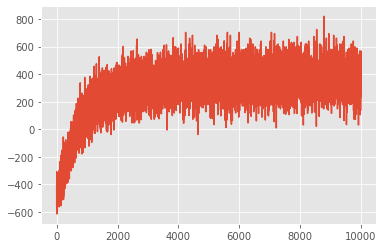

In [18]:
plt.plot(training_rewards);

And also the values of $\epsilon$ (useful for debugging purposes and tweaking the decay rate):

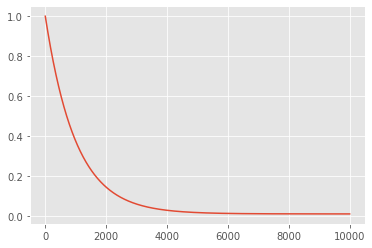

In [19]:
plt.plot(epsilons);

Let's visualize the behaviour of the learned policy in practice:

In [20]:
env = TaxiPickupEnvStandard()
state = env.reset()
for _ in range(1000):
    try:
        env.render()
        action = np.argmax(Q[state,:])
        state, reward, done, info = env.step(action)
        time.sleep(1)
        clear_output(wait=True)
        if done == True:
            env.render()
            break
    except KeyboardInterrupt:
        break
env.close()

+---------+
| :0| : : |
| : | : : |
| : : : : |
| | : | : |
|3| : |0: |
+---------+
T: 41; Total earnings: 120
Action: South; Reward: -1


Hopefully you managed to learn a policy that maybe does not perform perfectly, but does a pretty good job at maximizing rewards. 

Now try editing the ``TaxiPickupEnvStandard`` class in the file ``taxi_env.py`` and change either the request rate of one of the locations to be (much) higher than the others (i.e. simulating that one location is more popular than the others), or change the earnings of one of the locations such that pickups in that location lead to (much) higher rewards (e.g. simulating a "fancy" part of town where customers give very generous tips). Re-run the Q-learning algorithm and notice how the learned policy changes and how new behaviours emerge :-)

Hint: Look for the following lines in the ``taxi_env.py`` file:

``self.req_rates = req_rates = [5e-2, 5e-2, 5e-2]``

``if pickup_loc == 0: 
    reward = 20 
elif pickup_loc == 1:
    reward = 20 
elif pickup_loc == 2:
    reward = 20 ``

**Important: You will have to reload the TaxiPickupEnvStandard class in order for changes in taxi_env.py to take effect. Use the following code to reload. If that doesn't work, then restart the Python kernel from the Jupyter menus on the top.**

``import importlib
importlib.reload(taxi_env)``

# Part 3: Advanced environment (Deep Q-learning)

In this part, we will consider a more complex environment where pickup requests can appear anywhere on our 5x5 grid world. When there are requests in a map cell, we will represent that with a red counter showing the number of requests in that cell.

### Run Random Policy

As we have been doing before, let's start by having a look at how that environment looks like using a random policy:

In [21]:
env = TaxiPickupEnvAdvanced()
env.reset()
for _ in range(1000):
    try:
        env.render()
        state = env.step(env.action_space.sample()) # take a random action
        time.sleep(1)
        clear_output(wait=True)
    except KeyboardInterrupt:
        break
env.close()

+---------+
| : | : : |
| : | : : |
| : : : : |
| | : | : |
| | : | : |
+---------+
T: 3; Total earnings: 0
Action: West; Reward: -1


In [22]:
print("Action Space {}".format(env.action_space))

Action Space Discrete(5)


### Deep Q-learning (DQN)

As you probably realized already, when we start considering more interesting and more realistic problems, the dimensionality of the state space can quickly become unmanegeable for standard tabular Q-learning approaches. In the environment from Part 2, with just 3 possible pickup locations, the number of possible (discrete) states was already $5\times5\times2^3 = 200$. This is not a problem just because of memory requirements, but the learning task of fitting Q-table becomes much more complex (observations becomes sparser - curse of dimensionality)! Not only that, but what happens when the states are continuous rather than discrete? We definitely need a way of tackling these problems...

This is where function approximation comes in! In this tutorial, we will use neural networks as function approximators. This is also by far the most popular approach in the recent RL literature. To makes things easier, we will rely on 2 Python packages - keras and keras-rl - that abstract away many of the complexities involved in creating a neural network and using it for deep Q-learning.

**Optional: Implementing neural networks in Keras** (if you want, you may skip this part and treat the neural network as black-box function approximator)

Bulding a multi-layer neural network in Keras is fairly easy. We start by creating an object of the class "Sequential" (indicating that the neural network consists of sequence of layers):

```python
model = Sequential()
```

Now we can add layers to our neural network model. For examply, we can add a fully connected (dense) layer with 50 neurons and using a ReLU (rectified linear unit) activation function as follows:

```python
model.add(Dense(50, input_dim=30, activation='relu'))
```

A similar approach can be used for other types of layers such as Convolutional Layers. The following line adds a Convolutional layer with 20 filters of 3x3 convolutions:

```python
model.add(Conv2D(20, kernel_size=(3, 3), activation="relu"))
```
We can now keep adding more hidden layers, or add the final Dense layer. Note that since this is a regression problem (i.e. we want the neural network to output Q-value for the different possible actions given the state passed as input to it), the last layer (output layer) of network must necessarily have as many neurons/outputs as there are actions in our RL problem and it must use a linear activation:

```python
model.add(Dense(env.nA, activation='linear'))
```

**MDP formulation**:

Armed with the power of neural networks for function approximation, we can build a more complex representation of the environment state. In this case, we will represent the state using 4 5x5 matrices containing:

- Matrix 1: position of the taxi, one-hot encoded (i.e. with "1" in the place where the taxi is located, and zeros else where). For example:

``[[0,0,0,0,0],
 [0,0,0,0,0],
 [0,0,0,0,0],
 [0,0,0,1,0],
 [0,0,0,0,0]]``

- Matrix 2: number of pickup requests in each cell. For example:

``[[0,0,0,0,0],
 [0,0,0,1,0],
 [0,0,0,0,0],
 [2,0,0,0,4],
 [0,0,1,0,0]]``
 
- Matrix 3: information about the presence of walls to the east. In this case:

``[[0,1,0,0,0],
 [0,1,0,0,0],
 [0,0,0,0,0],
 [1,0,1,0,0],
 [1,0,1,0,0]]``
 
- Matrix 4: information about the presence of walls to the west. In this case:

``[[0,0,1,0,0],
 [0,0,1,0,0],
 [0,0,0,0,0],
 [0,1,0,1,0],
 [0,1,0,1,0]]``
 
We can stack these 4 matrices together to create a 5x5x4 tensor that represents the state of the environment, and feed it to the neural network as input. The idea is for the neural network to learn to approximate the Q-values (i.e. expected future rewards) for the different possible actions given the state that was passed as input.

Aside: we are not arguing that this is necessarily the best state representation for this problem. In fact, coming up with good state representation is a key challenge in deep RL and it can determine how fast your agent learns and how the policies that it learns can be. This state representation seems to perform acceptably well for this problem, so we will proceed with it.

In summary, the new MDP for this revised version of the problem can be formalized as:

**Actions:** north, south, east, west, pickup

**State:** 5x5x4 tensor representing the position of the taxi, the number of requests in each cell and the locations of the "walls"

**Reward:** +20 if taxi at a pickup location where there are requests and action is "pickup", else -1 (penalty for time elapsed); trying to pickup in a location different than the target also leads to penalty of -10.

The code below creates a neural network in Keras that performs well in this environment:

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Embedding, Reshape, Conv2D, MaxPooling2D, Input
from keras.optimizers import Adam

# First, we build a very simple neural network model in Keras
model = Sequential()
model.add(Input(shape=(1, env.num_rows, env.num_columns, 4)))
model.add(Reshape(target_shape=(env.num_rows, env.num_columns, 4)))
model.add(Conv2D(20, kernel_size=(3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(env.nA, activation='linear'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 5, 5, 4)           0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 20)          740       
_________________________________________________________________
flatten (Flatten)            (None, 180)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 905       
Total params: 1,645
Trainable params: 1,645
Non-trainable params: 0
_________________________________________________________________
None


Now that we have the neural network in place, it is time to use it as a function approximator for the Q-function of our RL agent. This can be easily done using the Keras-rl package in Python. The code below creates a deep Q-learning agent using $\epsilon$-greedy exploration:

In [24]:
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory

# Then, define DQN agent in Keras-RL
memory = SequentialMemory(limit=200000, window_length=1)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                              attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=100000)
dqn = DQNAgent(model=model, nb_actions=env.nA, memory=memory, policy=policy, 
               nb_steps_warmup=500, target_model_update=1e-2, enable_double_dqn=True, enable_dueling_network=True)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In essence, we are doing the exact some thing as we did before: Q-learning with $\epsilon$-greedy exploration. The key difference is in the way that we approximate the Q-function: before we used a table, and now we are using a neural network. 

As you can probably guess from the code above, we are also using a few popular RL techniques that improve the stability and convergence of Q-learning algorithms:

- Experience replay: we add a ``memory`` that allows the RL agent to "re-live" past experience but accounting for the latest knowledge that it has about the Q-function.

- Double deep Q networks (``enable_double_dqn=True``)

- Dueling networks (``enable_dueling_network=True``)

These fall outside of the scope of this tutorial, but they are explained in detail in the aditional materials provided in the last slides.

We can now run our deep Q-learning algorithm (in this case for 400000 steps, where each episode has a maximum of 200 steps):

In [25]:
dqn.fit(env, nb_steps=400000, visualize=False, verbose=1, nb_max_episode_steps=200, log_interval=10000)

Training for 400000 steps ...
Interval 1 (0 steps performed)
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
10000/10000 [==============================] - 79s 8ms/step - reward: -1.4167
50 episodes - episode_reward: -283.340 [-488.000, 124.000] - loss: 13.864 - mae: 14.810 - mean_q: 13.563 - mean_eps: 0.953

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -1.1464
50 episodes - episode_reward: -229.280 [-482.000, -53.000] - loss: 61.906 - mae: 100.863 - mean_q: 129.805 - mean_eps: 0.865

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 85s 8ms/step - reward: -0.7825
50 episodes - episode_reward: -156.500 [-356.000, 52.000] - loss: 120.319 - mae: 157.243 - mean_q: 200.484 - mean_eps: 0.775

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -0.8218
50 episodes - episode_reward:

Once the RL agent is learned, we can visualize the learned policy by exploiting the call-back functionality in Keras (don't worry if this code is a bit confusing for you as a first time Keras user; focus on the results that you obtained instead):

In [26]:
from keras.callbacks import Callback

class Visualizer(Callback):
    def __init__(self, env):
        self.env = env
    
    def on_action_end(self, action, logs):
        """ Render environment at the end of each action """
        self.env.render(mode='human')
        time.sleep(1)
        clear_output(wait=True)

In [27]:
try:
    dqn.test(env, nb_episodes=5, callbacks=[Visualizer(env)], nb_max_episode_steps=99, visualize=False, verbose=0)
except KeyboardInterrupt:
    pass

+---------+
| : | : : |
|2: | : : |
|1: : : : |
| | : | : |
| |1: | : |
+---------+
T: 98; Total earnings: 360
Action: North; Reward: -1


How are the results? Does the policy do what you would expect it to do? Or does it sometimes behaves strangely (i.e. not perfectly)? When I ran this code I managed to obtain a pretty good policy in a relatively short amount of time, but you can try doing a few tweaks to see if you improve. For example, try:

- Increasing the number of training steps ``nb_steps=400000``

- Increasing the maximum length of each episode ``nb_max_episode_steps=200``

- Increasing the complexity of the neural network (e.g. more layers or more neurons per layer)

- Changing the learning rate of the neural network optimizer ``Adam(lr=1e-3)``

- Other hyper-parameters of the RL algorithm (e.g. memory size, decay rate of $\epsilon$-greedy, etc.):

``memory = SequentialMemory(limit=200000, window_length=1)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                              attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=100000)
dqn = DQNAgent(model=model, nb_actions=env.nA, memory=memory, policy=policy, 
               nb_steps_warmup=500, target_model_update=1e-2, enable_double_dqn=True, enable_dueling_network=True)``

That's it! We hope that you enjoyed this brief introduction to the world of reinforcement learning :-)